In [15]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from Environment.Env import Agent_to_graph_assignment, cost_calculator
from Environment.Build import Generate_Graph
from Agents.CombUCB_agent import *
from Agents.Exp2_agent import *

%load_ext autoreload
%autoreload 2

# Graph creation

In [25]:
nb_iterations = 100
exploration_parameter = 1.5

V = 20# number of vertices
dropout_edge_rate = 0.9 # rate of edges to delete from the fully connected graph

generator = Generate_Graph(graph_type="Random_Sparse_graph", 
                           nb_vertices= V,
                           dropout_edge_rate=dropout_edge_rate)

# generator = Generate_Graph(graph_type="Sioux_Falls", 
#                            nb_vertices= V,
#                            dropout_edge_rate=dropout_edge_rate)

# generator = Generate_Graph(graph_type="OW", 
#                            nb_vertices= V,
#                            dropout_edge_rate=dropout_edge_rate)

g, adj_matrix, all_edges = generator.build()

# Agents creation

In [27]:
agents_sto = ['sto{}'.format(i) for i in range(1,5)]
agents_adv = ["adv{}".format(i) for i in range(1,5)]

agents = agents_sto + agents_adv

# Agents assignement on the created graph

In [28]:
assignement = Agent_to_graph_assignment(graph=g,
                                        list_agents_names = agents, 
                                        adj_matrix=adj_matrix)
agents_dicts = assignement.random_assignement()
agents_dicts

[{'name': 'sto1',
  'infos': {'start': 14,
   'destination': 6,
   'arms': [{'path': [14, 9, 10, 5, 18, 16, 1, 6]},
    {'path': [14, 9, 10, 6]},
    {'path': [14, 9, 10, 7, 18, 16, 1, 6]},
    {'path': [14, 11, 18, 5, 10, 6]},
    {'path': [14, 11, 18, 7, 10, 6]},
    {'path': [14, 11, 18, 16, 1, 6]},
    {'path': [14, 16, 1, 6]},
    {'path': [14, 16, 18, 5, 10, 6]},
    {'path': [14, 16, 18, 7, 10, 6]},
    {'path': [14, 17, 3, 10, 5, 18, 16, 1, 6]},
    {'path': [14, 17, 3, 10, 6]},
    {'path': [14, 17, 3, 10, 7, 18, 16, 1, 6]}]}},
 {'name': 'sto2',
  'infos': {'start': 19,
   'destination': 5,
   'arms': [{'path': [19, 15, 14, 9, 10, 5]},
    {'path': [19, 15, 14, 9, 10, 6, 1, 16, 18, 5]},
    {'path': [19, 15, 14, 9, 10, 7, 18, 5]},
    {'path': [19, 15, 14, 11, 18, 5]},
    {'path': [19, 15, 14, 11, 18, 7, 10, 5]},
    {'path': [19, 15, 14, 11, 18, 16, 1, 6, 10, 5]},
    {'path': [19, 15, 14, 16, 1, 6, 10, 5]},
    {'path': [19, 15, 14, 16, 1, 6, 10, 7, 18, 5]},
    {'path': [1

# Play interactions

In [31]:
summary_experiences= []

tracker_probas_over_arms_adv = {}
arms_possible = {}
edge_presence_in_arm_indexes = {}

for ind_agent, agent_name in enumerate(agents) :
    arms_possible[agent_name] = []
    for arm in agents_dicts[ind_agent]["infos"]['arms']:
        arms_possible[agent_name].append(arm["path"]) 


for t in range(nb_iterations):
    
    list_arms_pulled = []
    for ind_agent, agent_name in enumerate(agents) :
        if "sto" in agent_name :
            if t==0 :
                # initialisation
                visits_ini = {}
                for key in all_edges.keys():
                    visits_ini[key] = 1

                beliefs_hat_cost_edges = {} # beliefs of each agent
                own_history_of_visits = {} # history of visits of edges proper to each agent
                for agent_name in agents :
                    beliefs_hat_cost_edges[agent_name] = all_edges.copy()
                    own_history_of_visits[agent_name] = visits_ini.copy() # initializing the number of visits by 1
                
            agent_class = CombUCB_agent_part1(t=t, 
                                              arms_sto=arms_possible[agent_name], 
                                              dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                              history_visited_edges=own_history_of_visits[agent_name],
                                              exploration_parameter=exploration_parameter)
        if 'adv' in agent_name :
            if t == 0:
                # initialisation
                proba_over_arms = np.ones(len(arms_possible[agent_name]))/len(arms_possible[agent_name])
                tracker_probas_over_arms_adv[agent_name] = proba_over_arms
            agent_class = Exp2_agent_part1(t=t,
                                           arms_adv=arms_possible[agent_name],
                                           proba_over_arms=tracker_probas_over_arms_adv[agent_name])
            
        arm_to_play = agent_class.step()
        list_arms_pulled.append(arm_to_play)
        
        
    #######################################################################################################
    # Calculating the real costs after by running the agents on the graph each one following his own path 
    # given by his update strategy
    
    cc = cost_calculator(list_arms_pulled=list_arms_pulled, 
                         adj_matrix= adj_matrix)
    summary_round, history_costs_edges = cc.return_costs()
    summary_experiences.append(summary_round)
    
    #######################################################################################################    
    # Updates
    
    for ind_agent, agent_name in enumerate(agents) :
        if "sto" in agent_name:
            agent_class = CombUCB_agent_part2(arm_played=list_arms_pulled[ind_agent],
                                              cost_edges_observed=history_costs_edges,
                                              old_dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                              old_history_visited_edges=own_history_of_visits[agent_name])
            
            beliefs_hat_cost_edges[agent_name], own_history_of_visits[agent_name] = agent_class.update_own_statistics()
            
        if 'adv' in agent_name :
            
            if t == 0:
                # initialisation
                nrows = len(history_costs_edges.keys())
                ncols = len(arms_possible[agent_name])
                edge_presence_in_arm_indexes[agent_name] = np.zeros((nrows, ncols))
                for i, edge in enumerate(history_costs_edges.keys()):
                    s,d = edge[0], edge[1]
                    for j, arm in enumerate(arms_possible[agent_name]):
                        if any(arm[k]==s and arm[k+1]==d for k in range(len(arm)-1)):
                            edge_presence_in_arm_indexes[agent_name][i,j] = 1
                            
            agent_class = Exp2_agent_part2(t=t,
                                           arm_played=list_arms_pulled[ind_agent],
                                           arms_adv=arms_possible[agent_name],
                                           cost_edges_observed= history_costs_edges,
                                           old_proba_over_arms=tracker_probas_over_arms_adv[agent_name],
                                           edge_presence_in_arm_indexes=edge_presence_in_arm_indexes[agent_name]
                                          )
            tracker_probas_over_arms_adv[agent_name] = agent_class.update_own_statistics()

        
        

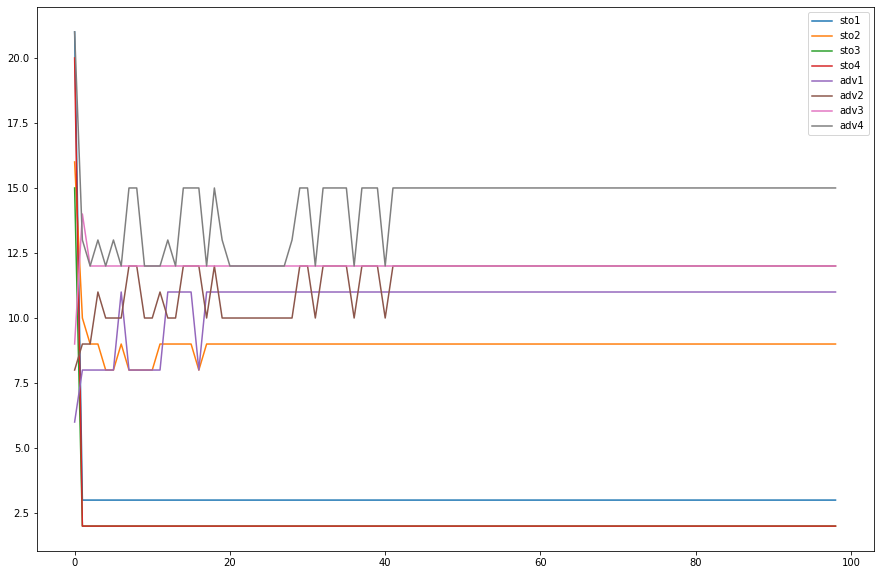

In [32]:
plt.figure(figsize=(15,10))

for ind_agent, agent_name in enumerate(agents):

    plt.plot(range(nb_iterations-1),
             [summary_experiences[t][ind_agent]["cost"] for t in range(nb_iterations-1)],
             label = agent_name)
plt.legend();

**Plotting Evolution of total cost:**

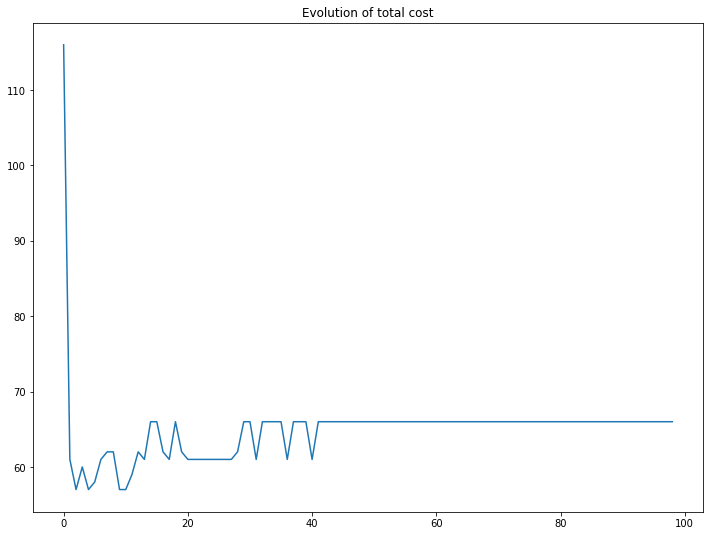

In [33]:
plt.figure(figsize=(12,9))
total_costs = list()
for t in range(nb_iterations-1):
    cost = sum([summary_experiences[t][ind_agent]["cost"] for ind_agent in range(len(agents))])
    total_costs.append(cost)
    
plt.plot(total_costs)
plt.title('Evolution of total cost')
plt.show()

**Computing Optimal Cost :**

In [34]:
assignement.get_optimal_paths(combinatorial=True, time_limit=60)

Time depassed 60 seconds, only 20354 combinations where tested
Total time to compute costs:60.00 s
 => The minimal cost is :  37.0
 => The optimal paths are :  [[14, 9, 10, 6], [19, 15, 14, 9, 10, 5], [1, 16, 18], [6, 10, 5], [2, 6, 10, 9], [4, 1, 16, 18], [4, 1, 6, 10, 5, 8], [19, 15, 14, 16, 1, 6, 2]]


***

In [35]:
summary_experiences[-1]

{0: {'path': [14, 9, 10, 6], 'cost': 3.0},
 1: {'path': [19, 15, 14, 16, 18, 5], 'cost': 9.0},
 2: {'path': [1, 16, 18], 'cost': 2.0},
 3: {'path': [6, 10, 5], 'cost': 2.0},
 4: {'path': [2, 6, 1, 16, 18, 11, 14, 17, 3, 10, 9], 'cost': 11.0},
 5: {'path': [4, 1, 16, 14, 9, 10, 7, 18], 'cost': 12.0},
 6: {'path': [4, 1, 16, 18, 11, 14, 17, 3, 10, 5, 8], 'cost': 12.0},
 7: {'path': [19, 15, 14, 17, 3, 10, 7, 18, 16, 1, 6, 2], 'cost': 15.0}}